In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import configs
import os
from auxrl.Agent import Agent
from auxrl.networks.Network import Network
import yaml

from acme import specs

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Foraging

In [3]:
from auxrl.environments.GridWorld import Env as Env 

In [4]:
dim = 16
nn_yaml = 'dm'
base_exp = 'tmp'
exp = f'{base_exp}_{nn_yaml}_dim{dim}'
fname = f'{base_exp}_mf'
_iter = 0

In [5]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [6]:
fname_nnet_dir = f'/mnt/smb/locker/aronov-locker/Ching/rl/nnets/{exp}/{fname}_{_iter}/'

In [7]:
with open(f'{engram_dir}params/{exp}/{fname}.yaml', 'r') as f:
    parameters = yaml.safe_load(f)

In [8]:
parameters['fname'] = f'{exp}/{fname}_{_iter}'
parameters['internal_dim'] = dim
parameters['nn_yaml'] = nn_yaml

In [9]:
env = Env(**parameters['dset_args'])

goal set
[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


In [10]:
env_spec = specs.make_environment_spec(env)
network = Network(env_spec, device=device, **parameters['network_args'])
agent = Agent(env_spec, network, device=device, **parameters['agent_args'])

In [11]:
with open(f'{fname_nnet_dir}goal.txt', 'r') as f:
    goal_state = f.read()
    print(goal_state)
goal_state = (int(goal_state[1]), int(goal_state[-2]))

(1, 6)


In [12]:
env.goal_state = goal_state

goal set
[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  1. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


In [14]:
agent.load_network(fname_nnet_dir, episode=200, encoder_only=False)

In [15]:
from auxrl.utils import run_eval_episode

In [16]:
import warnings
warnings.filterwarnings("ignore")

tensor([0.1288, 0.1226, 0.1052, 0.1317], device='cuda:0')
tensor([0.2355, 0.1743, 0.1615, 0.2222], device='cuda:0')
tensor([0.3810, 0.2434, 0.2343, 0.3472], device='cuda:0')
tensor([0.4946, 0.3093, 0.3027, 0.4658], device='cuda:0')
tensor([0.5612, 0.3897, 0.3696, 0.6177], device='cuda:0')
tensor([0.7057, 0.4675, 0.4534, 0.7526], device='cuda:0')
tensor([0.8679, 0.5341, 0.5395, 0.8417], device='cuda:0')
tensor([0.9142, 0.6277, 0.6012, 1.0412], device='cuda:0')
[EVAL] 1.0 score over 8.0 steps.


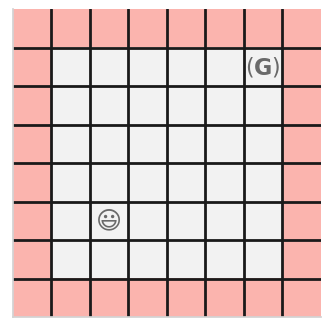

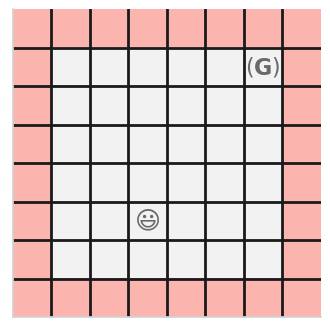

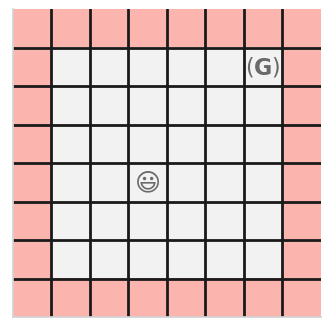

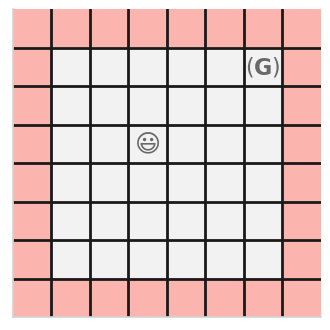

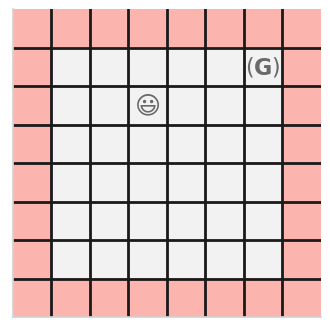

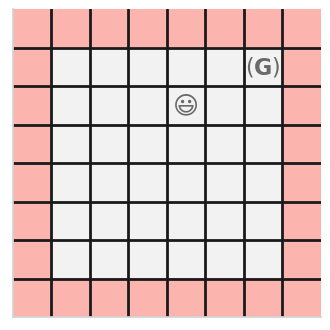

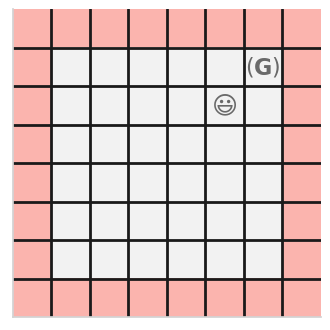

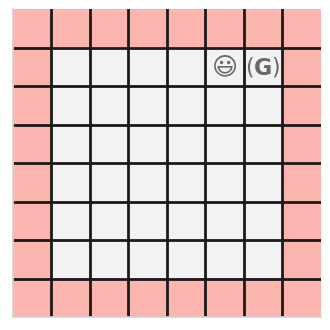

In [50]:
%matplotlib inline
env._start_state = env._sample_start()
score, steps_per_episode = run_eval_episode(env, agent, 1, verbose=True)

# Alternating T Maze

In [3]:
from auxrl.environments.AlternatingT import Env as Env 

In [4]:
dim = 16
nn_yaml = 'dm'
base_exp = 'tmp'
exp = f'{base_exp}_{nn_yaml}_dim{dim}'
fname = f'{base_exp}_mf'
_iter = 0

In [5]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
engram_dir = '/Volumes/aronov-locker/Ching/rl/'

In [6]:
fname_nnet_dir = f'{engram_dir}nnets/{exp}/{fname}_{_iter}/'

In [7]:
with open(f'{engram_dir}params/{exp}/{fname}.yaml', 'r') as f:
    parameters = yaml.safe_load(f)

In [8]:
parameters['fname'] = f'{exp}/{fname}_{_iter}'
parameters['internal_dim'] = dim
parameters['nn_yaml'] = nn_yaml

In [9]:
env = Env(**parameters['dset_args'])

In [10]:
env_spec = specs.make_environment_spec(env)
network = Network(env_spec, device=device, **parameters['network_args'])
agent = Agent(env_spec, network, device=device, **parameters['agent_args'])

In [11]:
agent.load_network(fname_nnet_dir, episode=50, encoder_only=False)

In [12]:
from auxrl.utils import run_eval_episode

In [13]:
import warnings
warnings.filterwarnings("ignore")

tensor([8.0577, 6.5775, 6.2990, 8.0247])
Standard move from (3, 1) to (2, 1)
tensor([8.8315, 7.2843, 7.0434, 7.0862])
Standard move from (2, 1) to (1, 1)
tensor([7.8821, 8.0472, 7.8498, 9.8579])
Standard move from (1, 1) to (1, 2)
tensor([ 8.7973,  8.8880,  8.8931, 10.9819])
Standard move from (1, 2) to (1, 3)
tensor([ 9.9381,  9.9827,  9.8568, 12.2063])
Left reward from (1, 3) to (1, 4)
New reward at (3, 1), last at LEFT
tensor([6.1844, 8.0161, 8.0152, 6.2000])
Standard move from (1, 4) to (2, 4)
tensor([7.1854, 8.9008, 7.0100, 6.9953])
Standard move from (2, 4) to (3, 4)
tensor([8.0052, 8.0013, 9.8790, 7.8917])
Standard move from (3, 4) to (3, 3)
tensor([ 8.8843,  8.8811, 10.9853,  8.8958])
Standard move from (3, 3) to (3, 2)
tensor([ 9.9940,  9.9891, 12.1883,  9.8760])
Transition from (3, 2) to (3, 1) reset
L: 2 is 2
Reset-from-left from (3, 2) to (3, 1)
New reward at (5, 4). last at RESET
tensor([6.4710, 7.9899, 6.1938, 7.9892])
Standard move from (3, 1) to (4, 1)
tensor([7.1944, 8

Standard move from (5, 2) to (5, 3)
tensor([ 9.9942,  9.9863,  9.8945, 12.2128])
Right reward from (5, 3) to (5, 4)
New reward at (3, 1). last at RIGHT
tensor([8.0081, 6.2123, 8.0026, 6.2014])
Standard move from (5, 4) to (4, 4)
tensor([8.9072, 7.2077, 6.9957, 6.9977])
Standard move from (4, 4) to (3, 4)
tensor([8.0052, 8.0013, 9.8790, 7.8917])
Standard move from (3, 4) to (3, 3)
tensor([ 8.8843,  8.8811, 10.9853,  8.8958])
Standard move from (3, 3) to (3, 2)
tensor([ 9.9940,  9.9891, 12.1883,  9.8760])
Transition from (3, 2) to (3, 1) reset
Reset-from-right from (3, 2) to (3, 1)
New reward at (1, 4). last at RESET
[EVAL] 100.0 score over 100.0 steps.


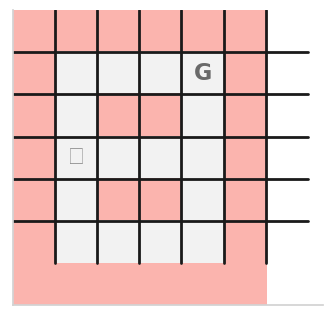

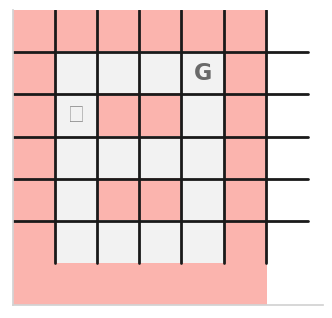

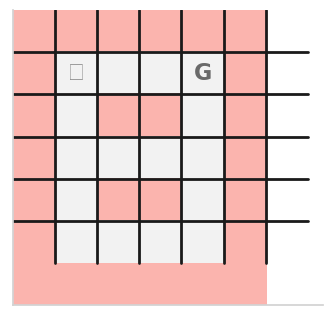

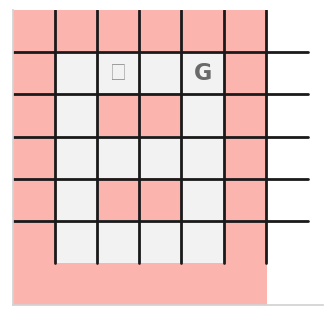

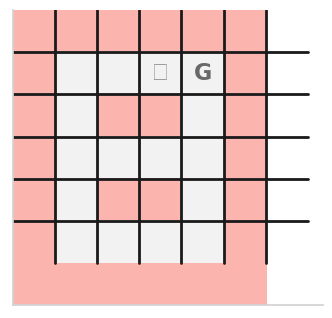

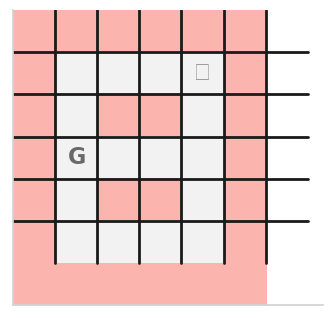

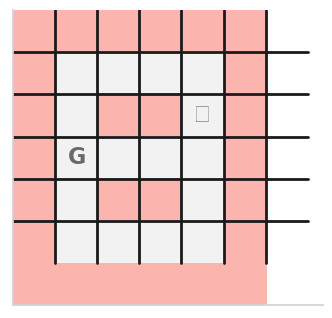

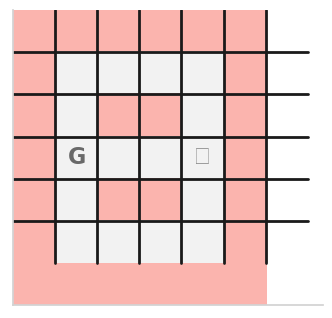

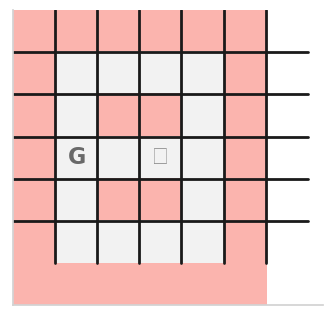

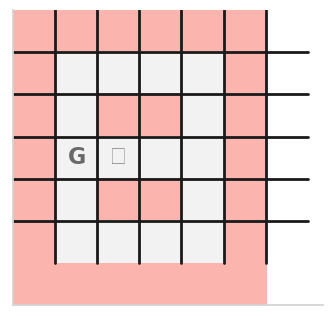

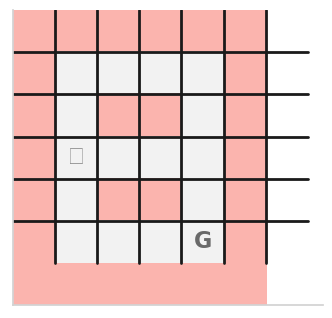

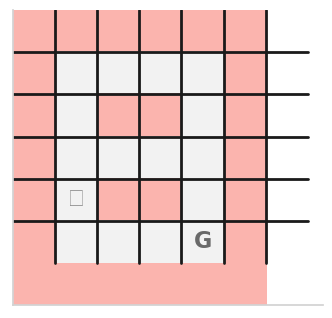

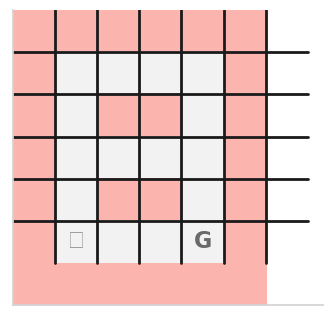

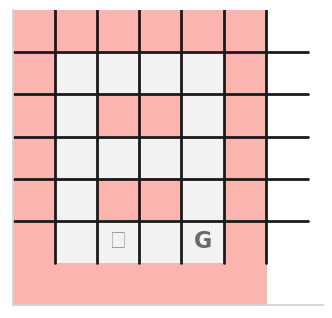

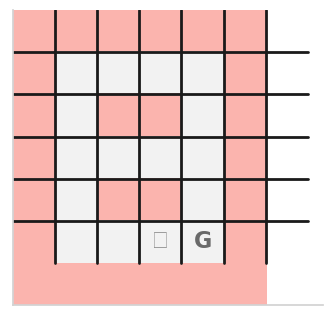

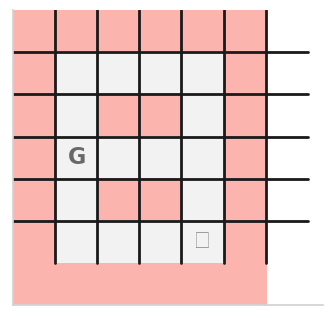

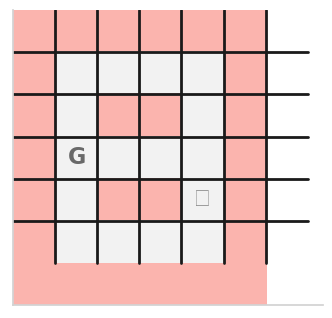

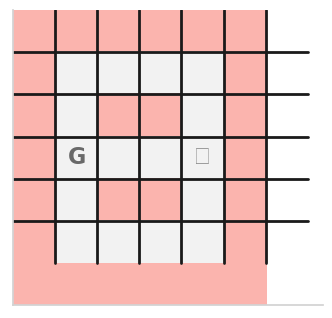

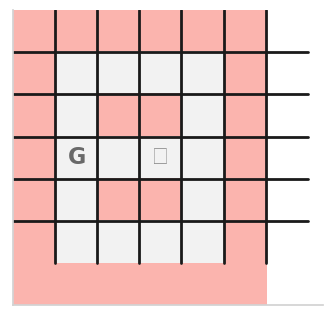

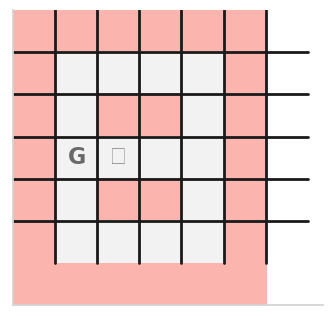

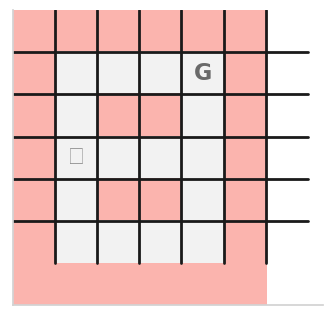

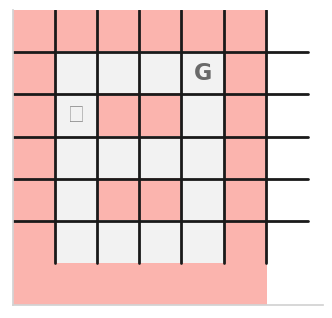

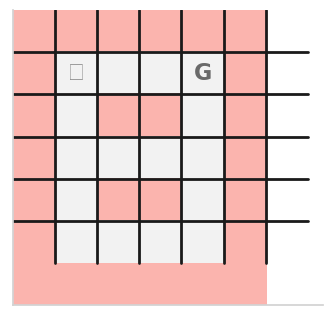

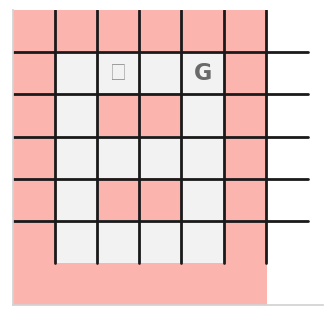

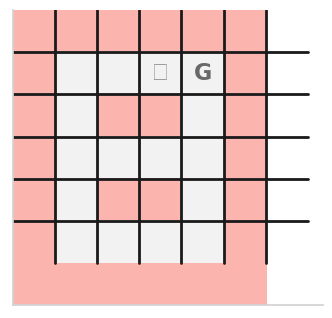

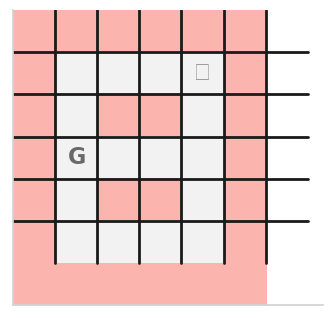

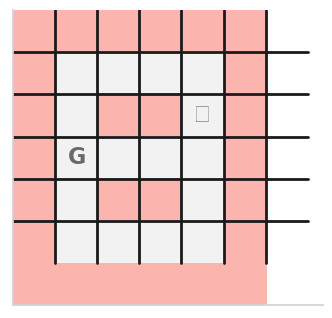

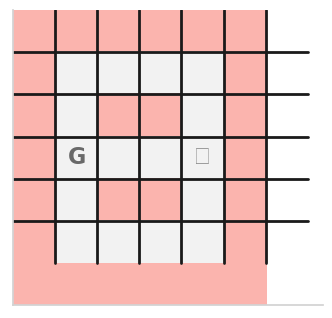

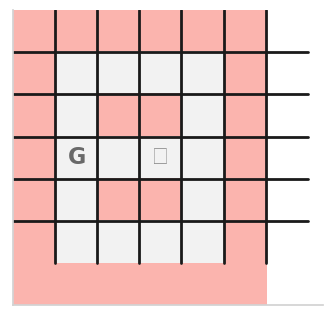

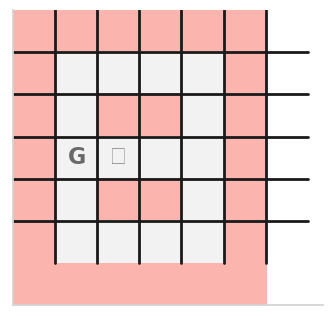

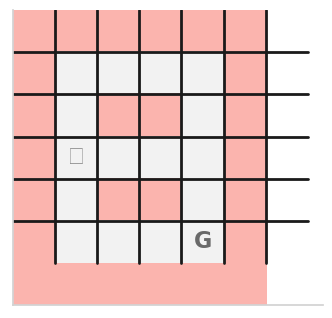

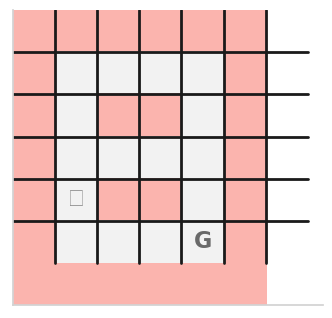

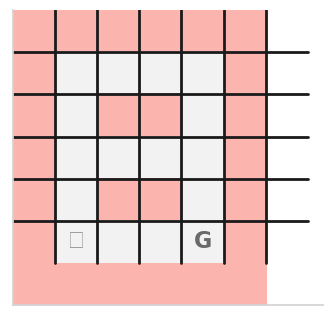

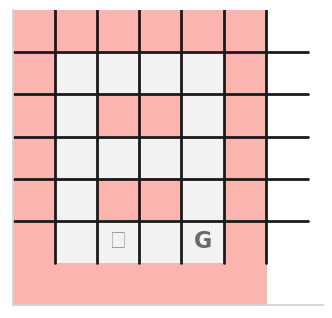

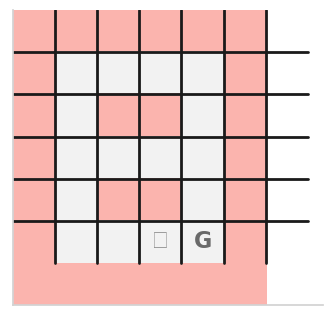

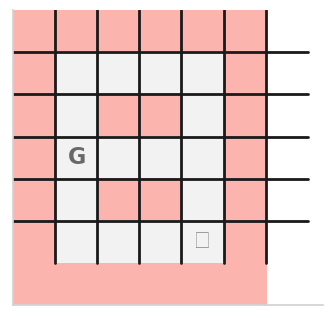

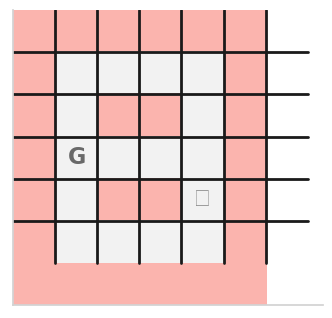

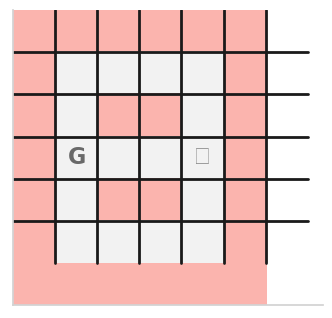

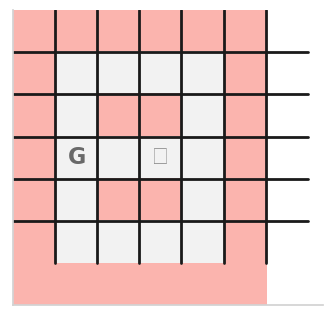

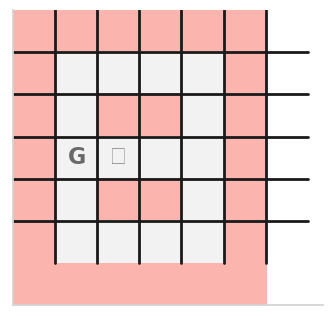

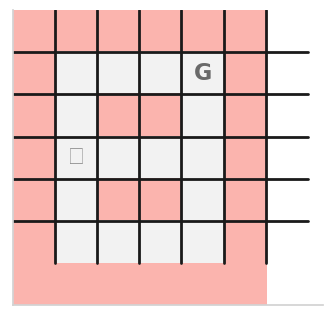

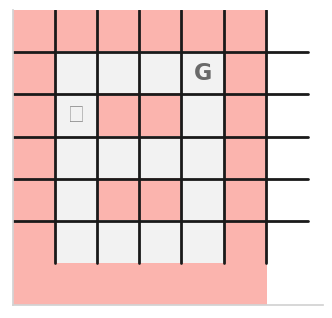

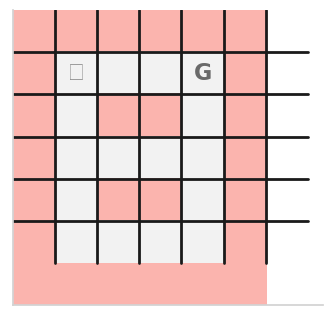

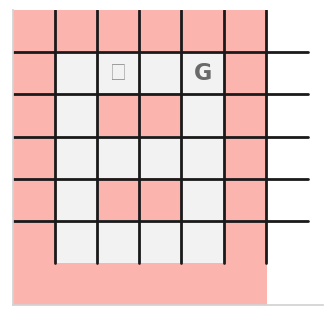

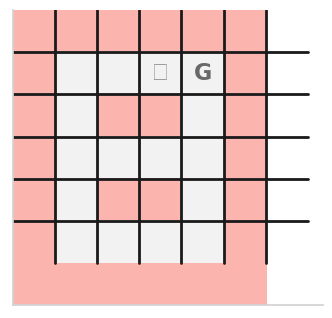

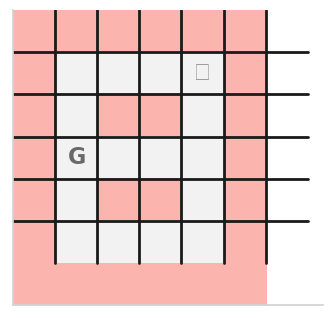

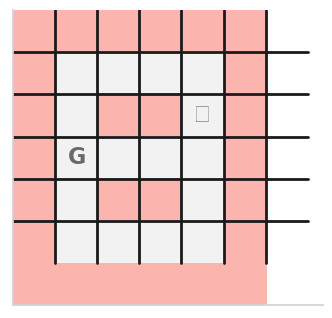

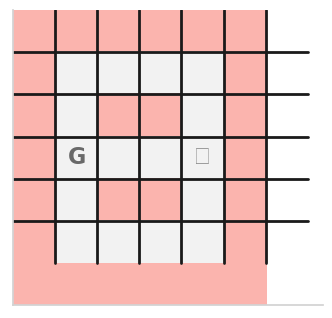

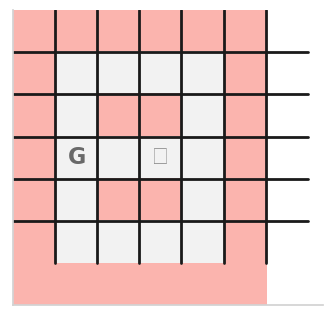

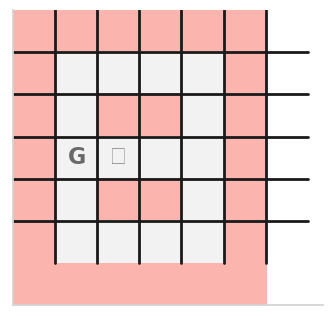

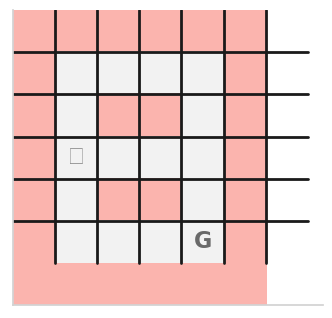

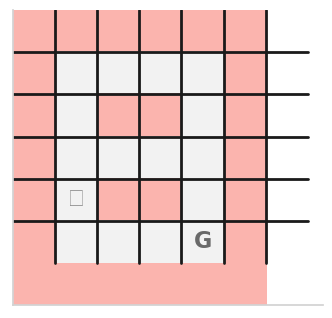

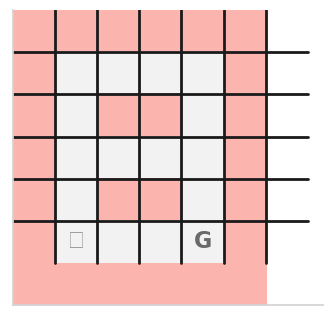

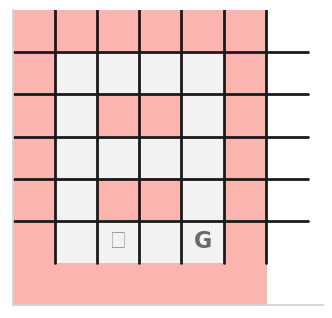

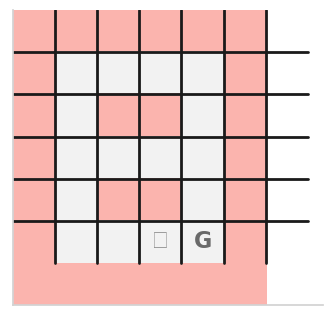

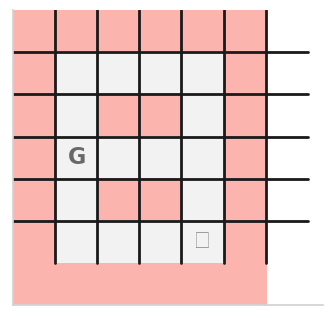

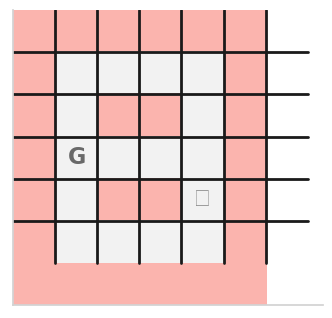

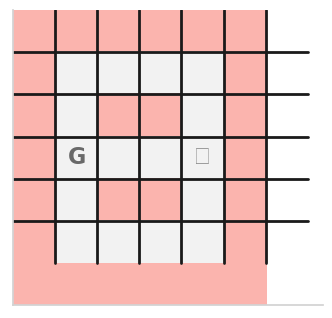

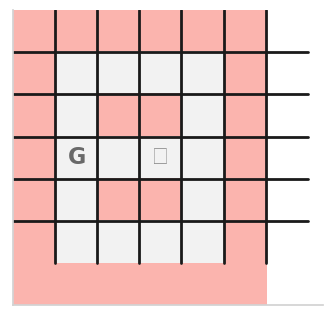

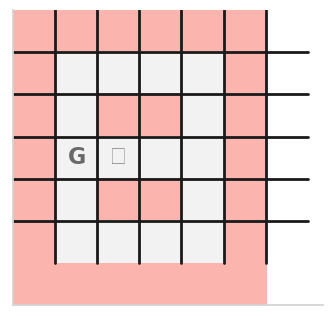

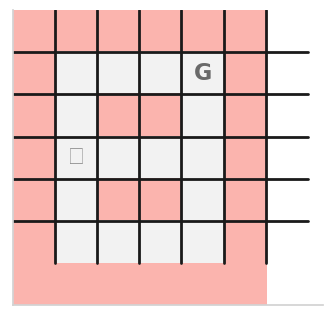

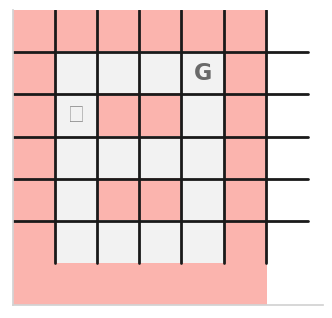

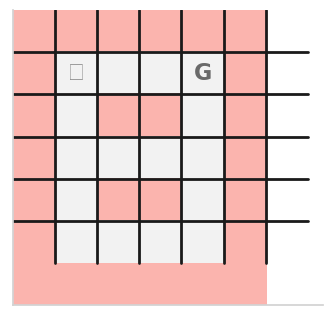

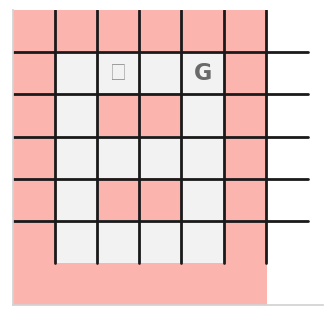

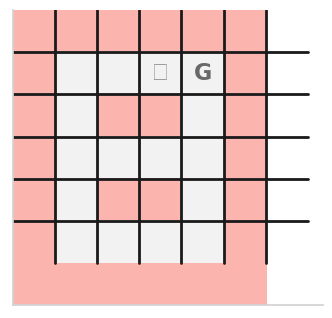

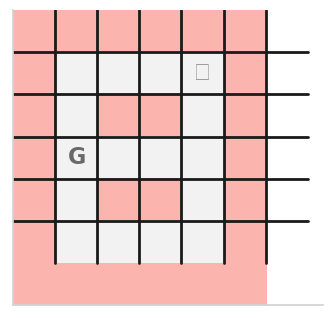

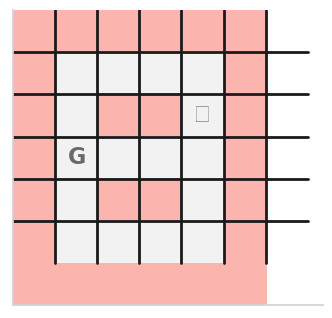

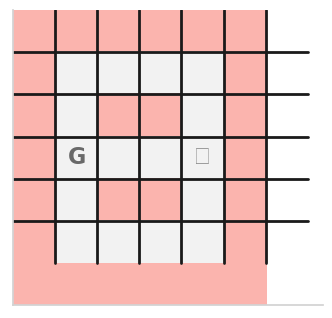

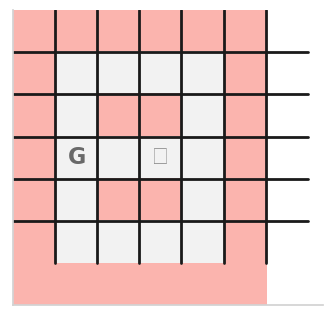

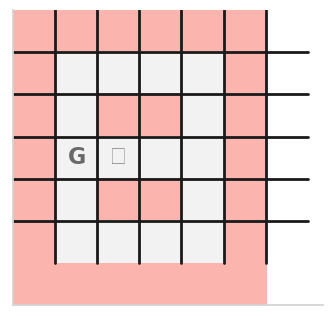

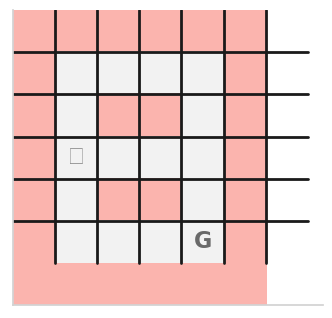

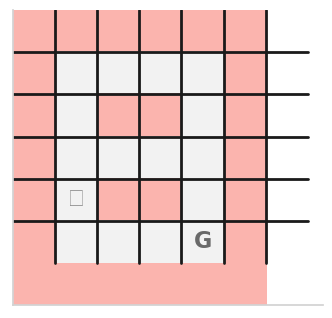

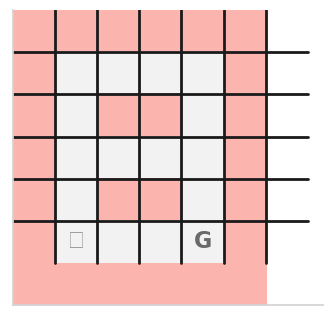

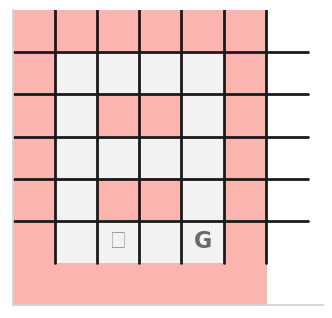

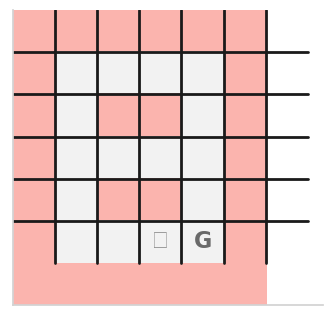

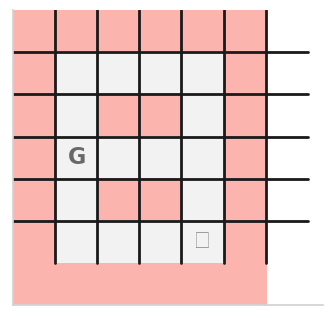

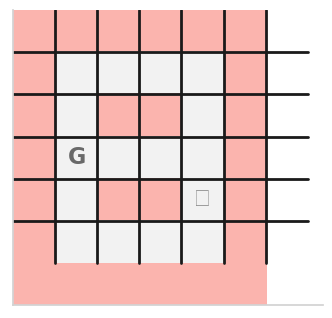

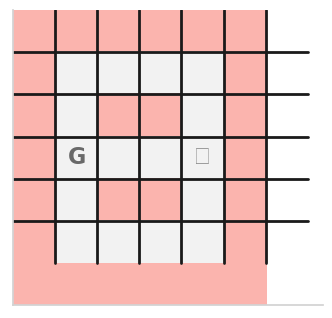

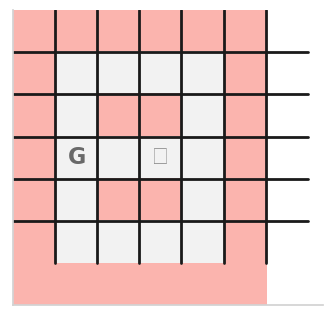

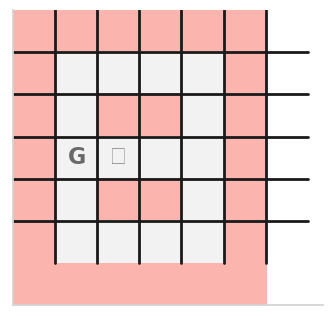

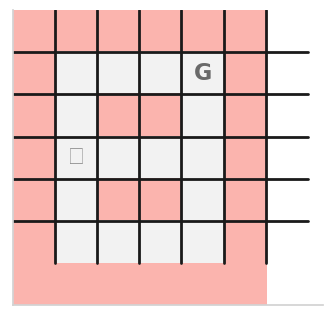

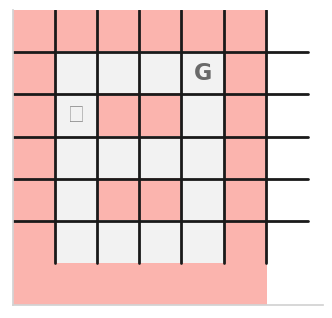

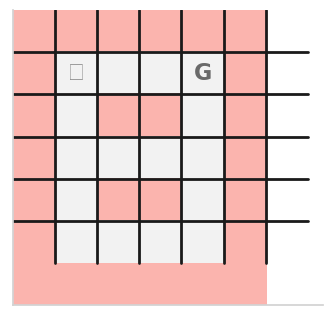

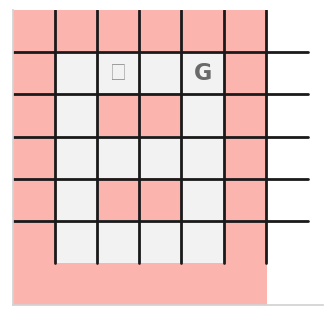

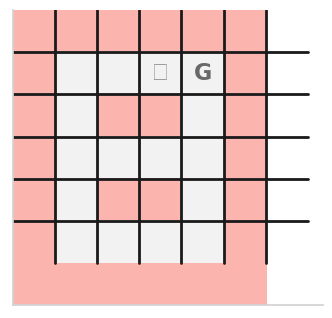

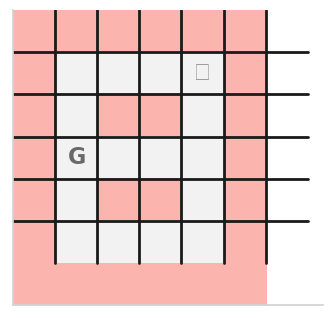

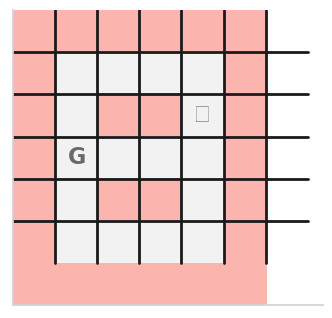

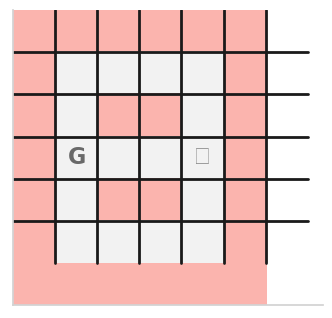

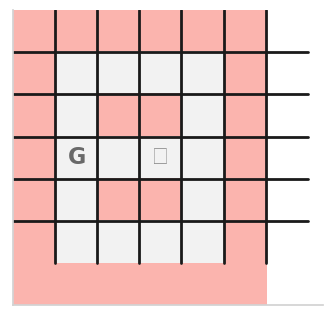

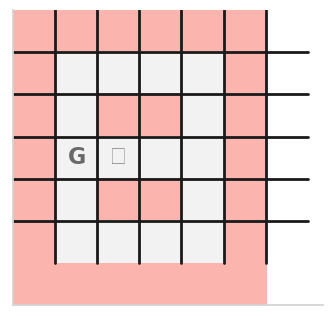

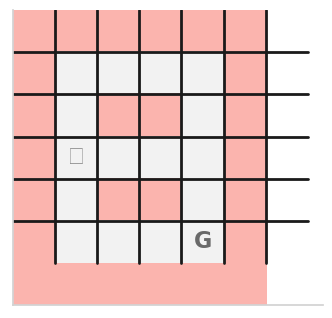

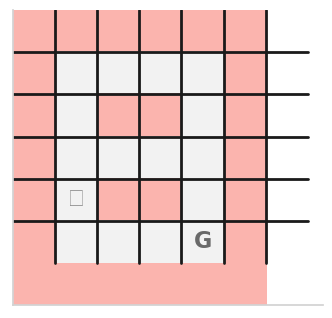

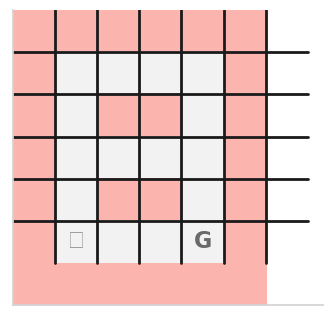

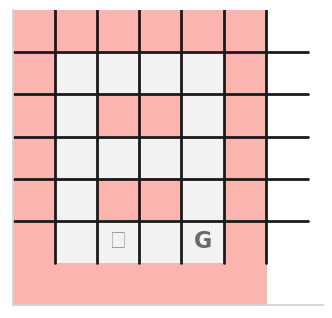

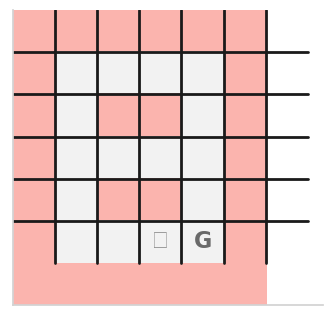

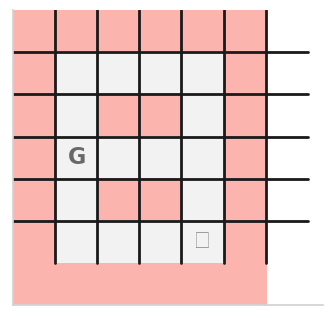

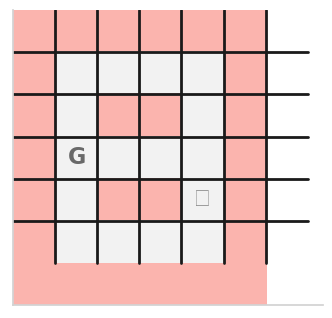

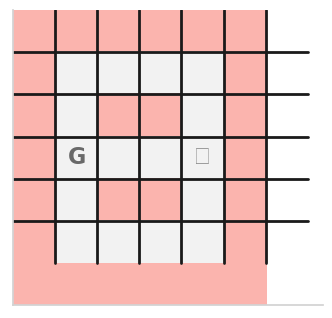

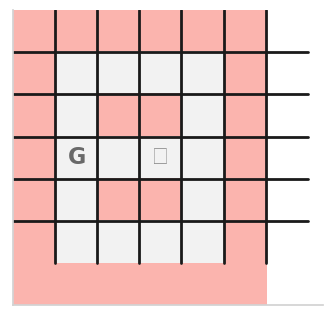

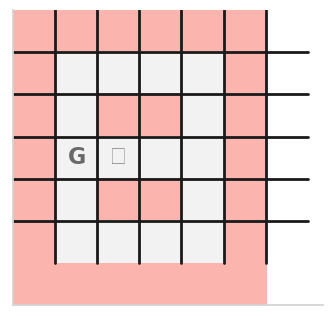

In [14]:
%matplotlib inline
score, steps_per_episode = run_eval_episode(env, agent, 1, verbose=True, max_episode_steps=100)